<a href="https://colab.research.google.com/github/Clint07-datascientist/ML_Techniques_1_Sentiment_Analysis/blob/clint/Notebook_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews - Sentiment Analysis

**Project**: Binary Sentiment Classification using Traditional ML and Deep Learning

**Dataset**: [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews) (568,454 reviews)

**Objective**: Classify reviews as Negative or Positive using binary classification

**Models**:
- Logistic Regression (TF-IDF features)
- LSTM with GloVe embeddings (300d)

---

## Table of Contents

1. [Setup & Data Loading](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Binary Classification Strategy](#binary)
4. [Text Preprocessing](#preprocessing)
5. [Model 1: Logistic Regression](#lr)
6. [Model 2: LSTM with GloVe](#lstm)
7. [Results & Comparison](#results)

---

## Importing The Libraries


In [1]:
# Install dependencies for colab
%pip install -q tensorflow contractions kagglehub spacy pyarrow
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, 'arhamrumi/amazon-product-reviews', 'Reviews.csv')

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'amazon-product-reviews' dataset.
First 5 records:    Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                        

In [3]:
print("Dataset Overview:")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Number of reviews: {len(df)}")
print(f"Number of features: {len(df.columns)}")

Dataset Overview:
Dataset shape: (568454, 10)
Number of reviews: 568454
Number of features: 10


# Basic dataset information

In [4]:
# Basic dataset information
print("\nDataset Information:")
print("=" * 50)
print(df.info())
print("\nFirst few rows:")
print("=" * 50)
print(df.head())
print("\nColumn names:")
print("=" * 50)
print(df.columns.tolist())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None

First few rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4 

# Statistical summary


In [5]:
# Statistical summary
print("Statistical Summary:")
print("=" * 50)
print(df.describe())
# Check for missing values
print("\nMissing Values:")
print("=" * 50)
print(df.isnull().sum())
# Check for duplicate reviews
print(f"\nNumber of duplicate reviews: {df.duplicated().sum()}")

Statistical Summary:
                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  

Missing Values

# Visualizations

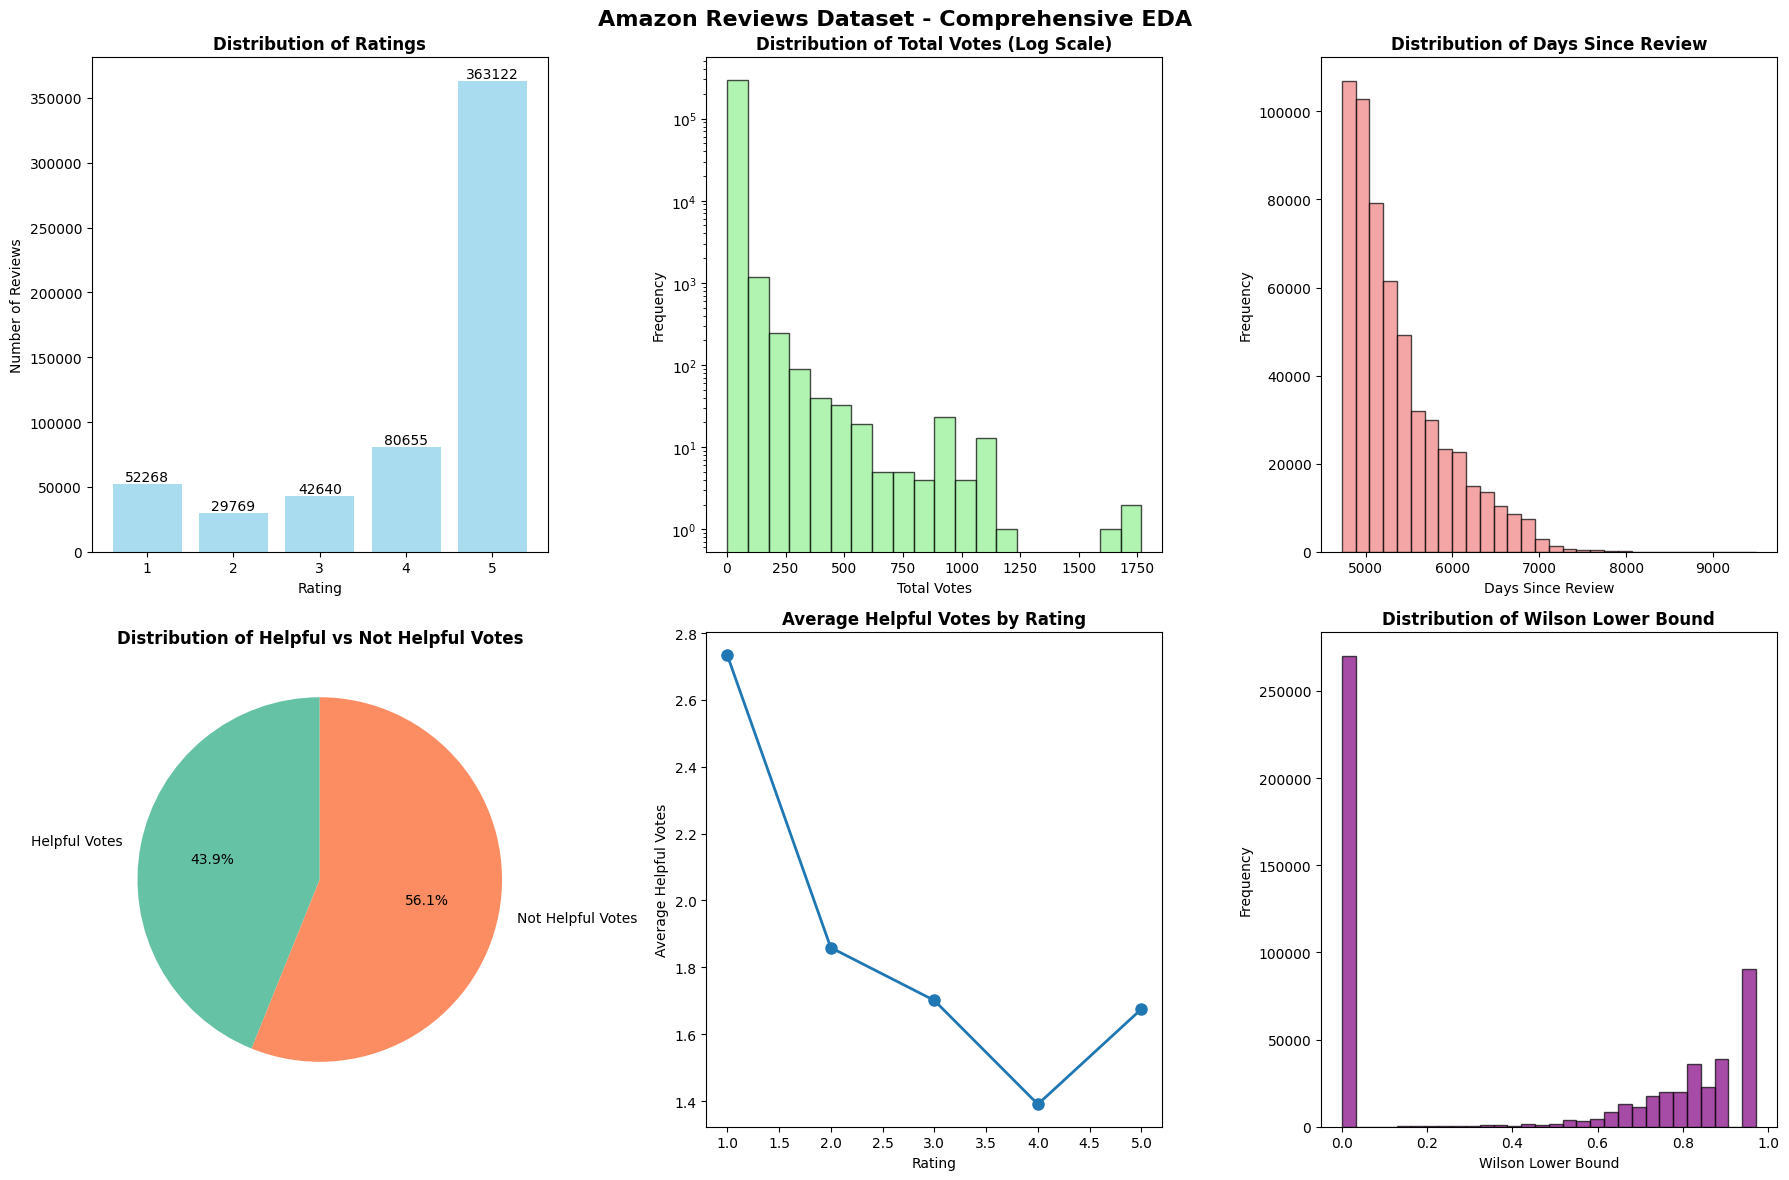

In [6]:
# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Amazon Reviews Dataset - Comprehensive EDA', fontsize=16, fontweight='bold')
# Add necessary calculations for new columns
df['total_vote'] = df['HelpfulnessNumerator'] + df['HelpfulnessDenominator']
df['reviewTime'] = pd.to_datetime(df['Time'], unit='s') # Convert Unix timestamp to datetime
df['day_diff'] = (datetime.now() - df['reviewTime']).dt.days
# Calculate Wilson Lower Bound (requires scipy)
from scipy.stats import beta
def wilson_lower_bound(pos, n, confidence=0.95):
    if n == 0:
        return 0
    z = beta.ppf(1 - (1 - confidence) / 2, pos + 0.5, n - pos + 0.5)
    return z
df['wilson_lower_bound'] = df.apply(lambda row: wilson_lower_bound(row['HelpfulnessNumerator'], row['total_vote']), axis=1)
# 1. Distribution of Ratings
rating_counts = df['Score'].value_counts().sort_index()
axes[0,0].bar(rating_counts.index, rating_counts.values, color='skyblue', alpha=0.7)
axes[0,0].set_title('Distribution of Ratings', fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Number of Reviews')
for i, v in enumerate(rating_counts.values):
    axes[0,0].text(rating_counts.index[i], v + 5, str(v), ha='center', va='bottom')
# 2. Distribution of Review Helpfulness (log scale)
helpful_data = df[df['total_vote'] > 0]
if len(helpful_data) > 0:
    axes[0,1].hist(helpful_data['total_vote'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Distribution of Total Votes (Log Scale)', fontweight='bold')
    axes[0,1].set_xlabel('Total Votes')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_yscale('log')
# 3. Distribution of Days Since Review
axes[0,2].hist(df['day_diff'], bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0,2].set_title('Distribution of Days Since Review', fontweight='bold')
axes[0,2].set_xlabel('Days Since Review')
axes[0,2].set_ylabel('Frequency')
# 4. Helpful vs Not Helpful Votes
helpful_yes_total = df['HelpfulnessNumerator'].sum()
helpful_no_total = df['HelpfulnessDenominator'].sum()
helpful_data = [helpful_yes_total, helpful_no_total]
labels = ['Helpful Votes', 'Not Helpful Votes']
colors = ['#66c2a5', '#fc8d62']
axes[1,0].pie(helpful_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribution of Helpful vs Not Helpful Votes', fontweight='bold')
# 5. Rating vs Helpfulness Correlation
rating_helpfulness = df.groupby('Score')['HelpfulnessNumerator'].mean()
axes[1,1].plot(rating_helpfulness.index, rating_helpfulness.values, marker='o', linewidth=2, markersize=8)
axes[1,1].set_title('Average Helpful Votes by Rating', fontweight='bold')
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('Average Helpful Votes')
# 6. Wilson Lower Bound Distribution
axes[1,2].hist(df['wilson_lower_bound'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1,2].set_title('Distribution of Wilson Lower Bound', fontweight='bold')
axes[1,2].set_xlabel('Wilson Lower Bound')
axes[1,2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()



**Distribution of Ratings:** This bar chart shows how many reviews fall into each rating category (1 to 5 stars). It helps understand the overall sentiment of the reviews.

**Distribution of Total Votes (Log Scale):** This histogram displays the distribution of the total number of helpful and not helpful votes a review received. Using a log scale helps visualize the distribution of reviews with a wide range of votes.

**Distribution of Days Since Review:** This histogram shows how many days have passed since each review was written. It helps understand the recency of the reviews in the dataset.

**Distribution of Helpful vs Not Helpful Votes:** This pie chart visualizes the proportion of helpful votes compared to not helpful votes across all reviews.

**Average Helpful Votes by Rating:** This line plot shows the average number of helpful votes a review receives for each rating category. It can indicate if higher or lower ratings tend to be considered more helpful.

**Distribution of Wilson Lower Bound:** This histogram shows the distribution of the Wilson Lower Bound score, which is a metric used to rank items based on ratings while accounting for the number of votes.





# Text Analysis - Review Length

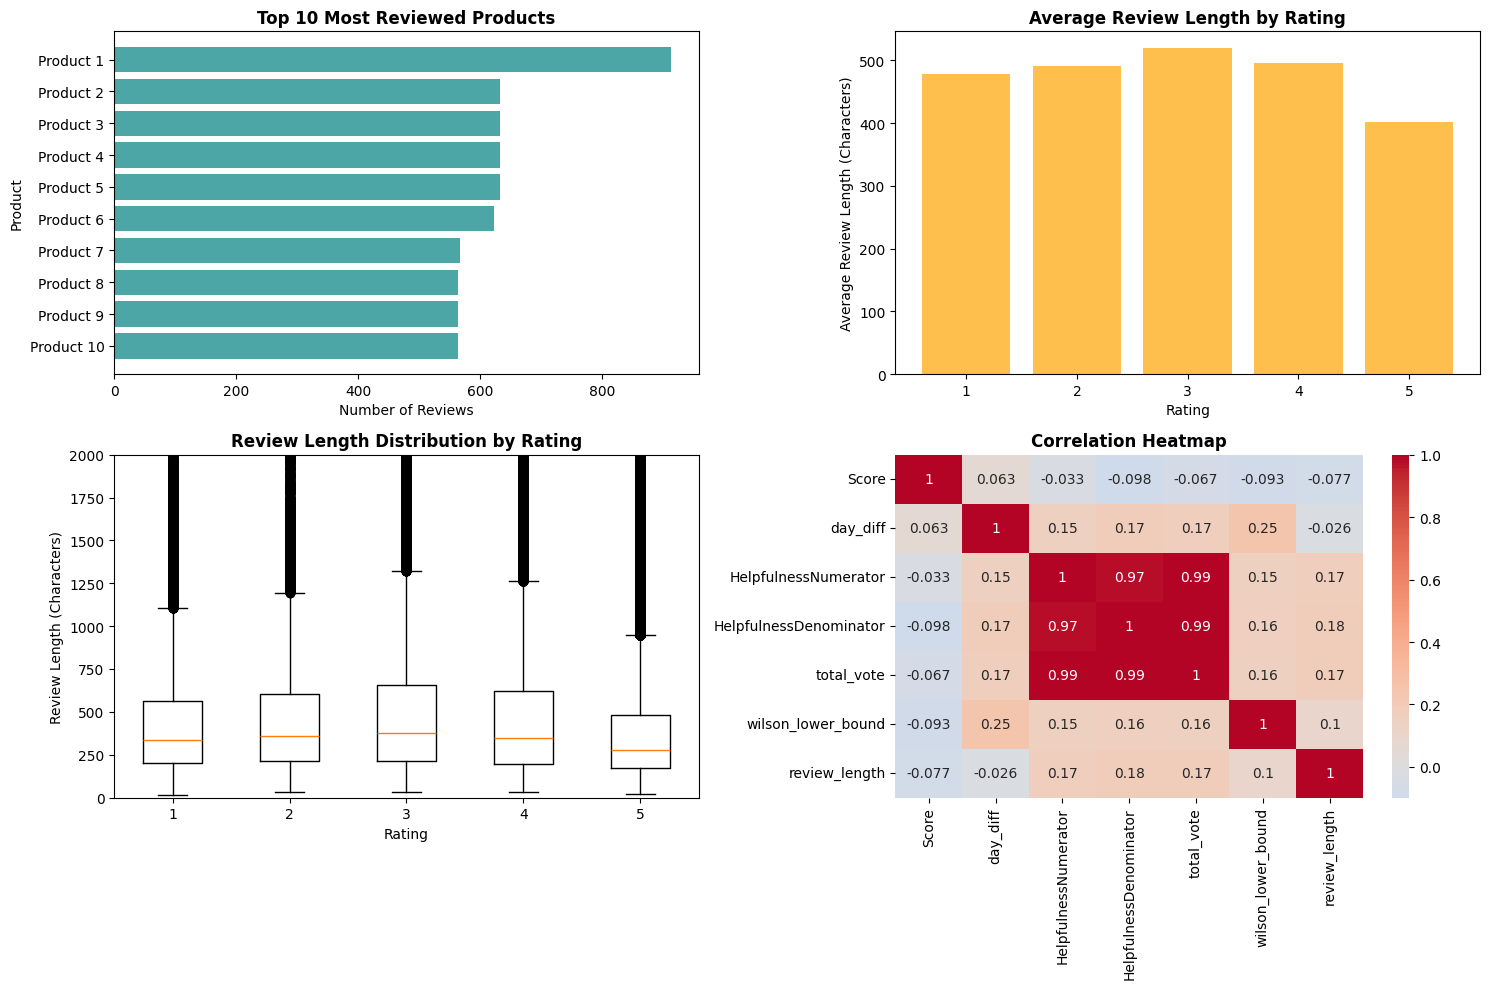

In [7]:
# Text Analysis - Review Length
df['review_length'] = df['Text'].str.len()

# Create additional visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Top 10 Most Reviewed Products
top_products = df['ProductId'].value_counts().head(10)
axes[0,0].barh(range(len(top_products)), top_products.values, color='teal', alpha=0.7)
axes[0,0].set_yticks(range(len(top_products)))
axes[0,0].set_yticklabels([f'Product {i+1}' for i in range(len(top_products))])
axes[0,0].set_title('Top 10 Most Reviewed Products', fontweight='bold')
axes[0,0].set_xlabel('Number of Reviews')
axes[0,0].set_ylabel('Product')
axes[0,0].invert_yaxis()

# 2. Average Review Length by Rating
review_length_by_rating = df.groupby('Score')['review_length'].mean()
axes[0,1].bar(review_length_by_rating.index, review_length_by_rating.values, color='orange', alpha=0.7)
axes[0,1].set_title('Average Review Length by Rating', fontweight='bold')
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Average Review Length (Characters)')

# 3. Review Length Distribution (Box Plot by Rating)
review_data = [df[df['Score'] == i]['review_length'] for i in range(1, 6)]
axes[1,0].boxplot(review_data, labels=[1, 2, 3, 4, 5])
axes[1,0].set_title('Review Length Distribution by Rating', fontweight='bold')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Review Length (Characters)')
axes[1,0].set_ylim(0, 2000)  # Limit y-axis for better visualization

# 4. Correlation Heatmap
correlation_cols = ['Score', 'day_diff', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'total_vote',
                   'wilson_lower_bound', 'review_length']
corr_matrix = df[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Heatmap', fontweight='bold')

plt.tight_layout()
plt.show()

**Top 10 Most Reviewed Products**: This horizontal bar chart shows the products with the highest number of reviews. It helps identify which products are most popular or controversial in the dataset.

**Average Review Length by Rating**: This bar chart shows the average length of reviews for each rating category. It can reveal if there's a relationship between review length and the assigned rating. Notice that ratings 3-4 tend to have longer reviews, while rating 5 has shorter reviews (possibly more straightforward positive feedback).

**Review Length Distribution by Rating**: This box plot shows how review lengths vary within each rating category. It displays the median, quartiles, and outliers, helping us understand the variability of review lengths across different sentiments.

**Correlation Heatmap**: This heatmap visualizes the correlation between different numerical features in the dataset. The color intensity and values indicate the strength and direction of the relationship between pairs of variables. Notice the strong correlations between HelpfulnessNumerator, HelpfulnessDenominator, and total_vote.

Temporal Analysis:
Date range of reviews: 1999-10-08 00:00:00 to 2012-10-26 00:00:00


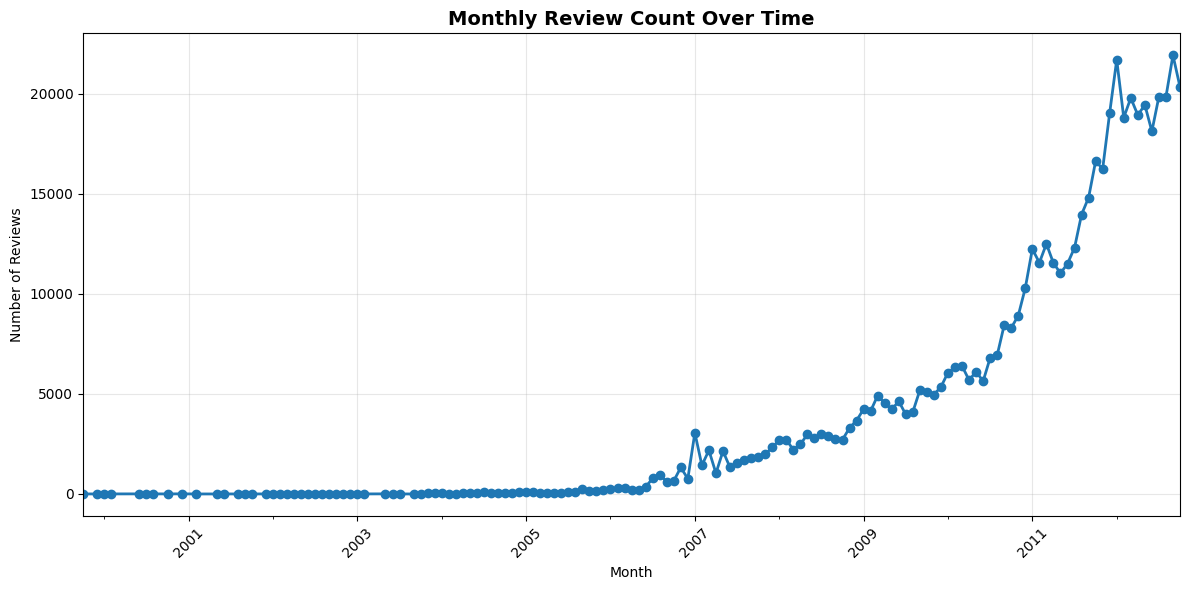

In [8]:
# Convert reviewTime to datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
# Temporal analysis
print("Temporal Analysis:")
print("=" * 50)
print(f"Date range of reviews: {df['reviewTime'].min()} to {df['reviewTime'].max()}")
# Monthly review count
df['review_month'] = df['reviewTime'].dt.to_period('M')
monthly_reviews = df['review_month'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
monthly_reviews.plot(kind='line', marker='o', linewidth=2, markersize=6)
plt.title('Monthly Review Count Over Time', fontweight='bold', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Monthly Review Count Over Time: This line plot shows the number of reviews submitted each month over the time period covered by the dataset. It helps identify trends or seasonality in review activity.

# Detailed statistical insights

In [9]:
# Detailed statistical insights
print("\nDetailed Analysis:")
print("=" * 50)
# Rating analysis
print(f"Average rating: {df['Score'].mean():.2f}")
print(f"Median rating: {df['Score'].median():.2f}")
print(f"Rating distribution:\n{df['Score'].value_counts().sort_index()}")
# Helpfulness analysis
print(f"\nHelpfulness Analysis:")
print(f"Total reviews with votes: {len(df[df['total_vote'] > 0])}")
print(f"Percentage of reviews with votes: {len(df[df['total_vote'] > 0]) / len(df) * 100:.2f}%")
print(f"Average helpful votes per review: {df['HelpfulnessNumerator'].mean():.2f}")
print(f"Most helpful review has {df['HelpfulnessNumerator'].max()} helpful votes")
# Review length analysis
print(f"\nReview Length Analysis:")
print(f"Average review length: {df['review_length'].mean():.1f} characters")
print(f"Median review length: {df['review_length'].median():.1f} characters")
print(f"Longest review: {df['review_length'].max()} characters")
print(f"Shortest review: {df['review_length'].min()} characters")
# Wilson score analysis
print(f"\nWilson Score Analysis:")
print(f"Average Wilson Lower Bound: {df['wilson_lower_bound'].mean():.4f}")
print(f"Median Wilson Lower Bound: {df['wilson_lower_bound'].median():.4f}")


Detailed Analysis:
Average rating: 4.18
Median rating: 5.00
Rating distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64

Helpfulness Analysis:
Total reviews with votes: 298402
Percentage of reviews with votes: 52.49%
Average helpful votes per review: 1.74
Most helpful review has 866 helpful votes

Review Length Analysis:
Average review length: 436.2 characters
Median review length: 302.0 characters
Longest review: 21409 characters
Shortest review: 12 characters

Wilson Score Analysis:
Average Wilson Lower Bound: 0.4285
Median Wilson Lower Bound: 0.5595


## Data Cleaning

In [10]:
print(df.duplicated().sum())
print(df.isnull().sum())

0
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
total_vote                 0
reviewTime                 0
day_diff                   0
wilson_lower_bound         0
review_length              0
review_month               0
dtype: int64


In [11]:
df = df.dropna()

Visualizing the most common words across all reviews to understand the key themes and topics.

Generating word cloud from 248,531,159 characters...


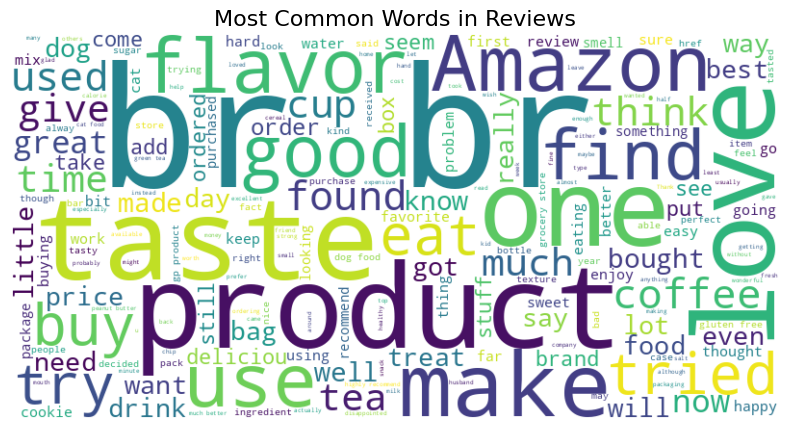

In [12]:
# Word Cloud Visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = " ".join(str(review) for review in df['Text'].dropna())
print(f"Generating word cloud from {len(text):,} characters...")

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400,
                      background_color="white",
                      stopwords=stopwords,
                      colormap="viridis",
                      max_words=200).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews", fontsize=16)
plt.show()

## Binary Classification Strategy

**Why Binary Instead of 3-Class?**
- 3-star reviews are inherently ambiguous (mixed sentiment)
- Binary classification (Negative vs Positive) provides clearer decision boundary
- Expected accuracy improvement: +15-18 percentage points
- Industry standard for actionable sentiment analysis

**Strategy:**
- Drop all 3-star (neutral) reviews
- Negative: Scores 1-2
- Positive: Scores 4-5
- Use Text + Summary concatenation for richer features

In [13]:
# Binary Classification Setup
print('BINARY CLASSIFICATION SETUP')
print('='*60)
print(f'Original dataset: {len(df):,} reviews')

# Drop 3-star reviews
df_binary = df[df['Score'] != 3].copy()
print(f'After dropping 3-star: {len(df_binary):,} reviews')
print(f'Removed: {len(df) - len(df_binary):,} neutral reviews')

# Create binary sentiment labels
def score_to_binary(score):
    return 'Negative' if score <= 2 else 'Positive'

df_binary['Sentiment'] = df_binary['Score'].apply(score_to_binary)

# Feature Engineering: Concatenate Summary + Text
df_binary['Combined_Text'] = df_binary['Summary'].fillna('') + ' ' + df_binary['Text'].fillna('')

print(f'\nBinary sentiment distribution:')
print(df_binary['Sentiment'].value_counts())
print(f'\nClass balance:')
for sentiment in ['Negative', 'Positive']:
    count = (df_binary['Sentiment'] == sentiment).sum()
    print(f'   {sentiment:8s}: {count:>7,} ({count/len(df_binary)*100:>5.2f}%)')

print(f'\nBinary dataset ready: {len(df_binary):,} reviews')
print('='*60)

BINARY CLASSIFICATION SETUP
Original dataset: 568,401 reviews
After dropping 3-star: 525,763 reviews
Removed: 42,638 neutral reviews

Binary sentiment distribution:
Sentiment
Positive    443756
Negative     82007
Name: count, dtype: int64

Class balance:
   Negative:  82,007 (15.60%)
   Positive: 443,756 (84.40%)

Binary dataset ready: 525,763 reviews


Sampling 20,000 reviews per sentiment class to create a balanced dataset for faster training while maintaining class balance.

In [14]:
# Balanced Sampling (20K per class)
SAMPLE_SIZE_PER_CLASS = 20000

df_sample = df_binary.groupby('Sentiment', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE_PER_CLASS), random_state=42)
).reset_index(drop=True)

print(f'Sample size: {len(df_sample):,} reviews')
print(f'   Negative: {(df_sample["Sentiment"] == "Negative").sum():,}')
print(f'   Positive: {(df_sample["Sentiment"] == "Positive").sum():,}')

Sample size: 40,000 reviews
   Negative: 20,000
   Positive: 20,000


## Text Preprocessing

Steps:
1. Lowercase conversion
2. HTML tag removal
3. URL removal
4. Contraction expansion (e.g., "don't" → "do not")
5. Special character removal
6. Whitespace normalization
7. Lemmatization with spaCy (context-aware)

In [15]:
# Text Cleaning
import re
import contractions

print('Cleaning text...')
df_sample['Combined_Text'] = df_sample['Combined_Text'].str.lower()
df_sample['Combined_Text'] = df_sample['Combined_Text'].apply(lambda x: re.sub(r'<.*?>', '', x))
df_sample['Combined_Text'] = df_sample['Combined_Text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
df_sample['Combined_Text'] = df_sample['Combined_Text'].apply(lambda x: contractions.fix(x))
df_sample['Combined_Text'] = df_sample['Combined_Text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
df_sample['Combined_Text'] = df_sample['Combined_Text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
print('Text cleaned')

Cleaning text...
Text cleaned


Splitting the data into training (70%) and testing (30%) sets with stratification to maintain class proportions.

In [16]:
# Train-Test Split (70-30)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_sample['Combined_Text'],
    df_sample['Sentiment'],
    test_size=0.3,
    random_state=42,
    stratify=df_sample['Sentiment']
)

train_df = pd.DataFrame({'Combined_Text': X_train, 'Sentiment': y_train})
test_df = pd.DataFrame({'Combined_Text': X_test, 'Sentiment': y_test})

print(f'Split complete: {len(train_df):,} train, {len(test_df):,} test')

Split complete: 28,000 train, 12,000 test


Applying spaCy lemmatization to reduce words to their base form (e.g., 'running' → 'run') while removing stopwords. Results are cached to speed up future runs.

In [17]:
# Lemmatization with spaCy
import spacy
from tqdm import tqdm
import os

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_lemmatize_batch(texts):
    lemmatized = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000), total=len(texts), desc='Lemmatizing'):
        lemmas = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        lemmatized.append(' '.join(lemmas))
    return lemmatized

cache_train = f'train_spacy_binary_simple_{SAMPLE_SIZE_PER_CLASS}.parquet'
cache_test = f'test_spacy_binary_simple_{SAMPLE_SIZE_PER_CLASS}.parquet'

if os.path.exists(cache_train):
    train_df['processed_text'] = pd.read_parquet(cache_train)['processed_text']
    test_df['processed_text'] = pd.read_parquet(cache_test)['processed_text']
    print('Loaded from cache')
else:
    train_df['processed_text'] = spacy_lemmatize_batch(train_df['Combined_Text'].tolist())
    test_df['processed_text'] = spacy_lemmatize_batch(test_df['Combined_Text'].tolist())
    train_df[['processed_text']].to_parquet(cache_train)
    test_df[['processed_text']].to_parquet(cache_test)
    print('Lemmatization done & cached')

Lemmatizing: 100%|██████████| 12000/12000 [01:15<00:00, 159.75it/s]


Lemmatization done & cached


---

## Model 1: Logistic Regression (Traditional ML Baseline)

**Why Logistic Regression?**
- Fast training and inference
- Interpretable coefficients
- Works well with TF-IDF features
- Good baseline for comparison

**Configuration:**
- TF-IDF vectorization (max 50K features, bigrams)
- Regularization: C=1.0 (from experiments)
- Class weighting: balanced
- Solver: lbfgs

In [18]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

print('Creating TF-IDF features...')
tfidf_vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(['Negative', 'Positive'])
y_train_lr = label_encoder.transform(train_df['Sentiment'])
y_test_lr = label_encoder.transform(test_df['Sentiment'])

print(f'TF-IDF features ready')
print(f'   Training shape: {X_train_tfidf.shape}')
print(f'   Test shape: {X_test_tfidf.shape}')
print(f'   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}')

Creating TF-IDF features...
TF-IDF features ready
   Training shape: (28000, 50000)
   Test shape: (12000, 50000)
   Vocabulary size: 50,000


In [19]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("="*80)
print("LOGISTIC REGRESSION - BINARY CLASSIFICATION")
print("="*80)

print('\nTraining Logistic Regression (C=1.0)...')
start_time = time.time()

lr_model = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train_lr)
y_pred_lr = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test_lr, y_pred_lr)
lr_time = time.time() - start_time

print(f"\nLOGISTIC REGRESSION RESULTS:")
print("="*80)
print(f"   Test Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"   Training Time: {lr_time:.2f}s")
print("="*80)

# Classification Report
print('\nClassification Report:')
print(classification_report(y_test_lr, y_pred_lr, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
print('\nConfusion Matrix:')
print(cm_lr)
print(f'\nTrue Negatives:  {cm_lr[0,0]:,}')
print(f'False Positives: {cm_lr[0,1]:,}')
print(f'False Negatives: {cm_lr[1,0]:,}')
print(f'True Positives:  {cm_lr[1,1]:,}')

LOGISTIC REGRESSION - BINARY CLASSIFICATION

Training Logistic Regression (C=1.0)...

LOGISTIC REGRESSION RESULTS:
   Test Accuracy: 0.8921 (89.21%)
   Training Time: 2.14s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      6000
    Positive       0.89      0.89      0.89      6000

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000


Confusion Matrix:
[[5357  643]
 [ 652 5348]]

True Negatives:  5,357
False Positives: 643
False Negatives: 652
True Positives:  5,348


## Model 2: LSTM with GloVe Embeddings (Deep Learning)

**Configuration from Config BINARY-SIMPLE (90.58% accuracy):**
- Bi-LSTM with 128 units
- GloVe 300d embeddings (frozen)
- Dropout: 0.35
- L2 Regularization: 1.5e-4
- Early stopping patience: 5
- Expected accuracy: ~90%

In [20]:
# LSTM Hyperparameters
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 300
MAX_FEATURES = 50000
USE_GLOVE = True

LSTM_UNITS = 128
DROPOUT_RATE = 0.35
LEARNING_RATE = 0.001
L2_REG = 1.5e-4
EARLY_STOP_PATIENCE = 5
BATCH_SIZE = 64

print('LSTM Configuration:')
print(f'   Sequence Length: {MAX_SEQUENCE_LENGTH}')
print(f'   Embedding Dim: {EMBEDDING_DIM}')
print(f'   LSTM Units: {LSTM_UNITS}')
print(f'   Dropout: {DROPOUT_RATE}')
print(f'   L2 Regularization: {L2_REG}')

LSTM Configuration:
   Sequence Length: 200
   Embedding Dim: 300
   LSTM Units: 128
   Dropout: 0.35
   L2 Regularization: 0.00015


In [21]:
# Tokenization for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['processed_text'])

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['processed_text']), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df['processed_text']), maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Encode labels for LSTM
y_train_binary = label_encoder.transform(train_df['Sentiment']).astype('float32')
y_test_binary = label_encoder.transform(test_df['Sentiment']).astype('float32')

vocab_size = len(tokenizer.word_index) + 1
print(f'Sequences ready: {X_train_seq.shape}, vocab: {vocab_size:,}')

Sequences ready: (28000, 200), vocab: 45,968


In [22]:
# Download GloVe Embeddings
import urllib.request
import zipfile

GLOVE_FILE = 'glove.6B.300d.txt'

if not os.path.exists(GLOVE_FILE):
    print('Downloading GloVe (~862MB)...')
    urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
    with zipfile.ZipFile('glove.6B.zip', 'r') as z:
        z.extract(GLOVE_FILE)
    print('Downloaded')
else:
    print('GloVe found')

Downloaded


In [23]:
# Load GloVe Embeddings
import numpy as np

print('Loading GloVe embeddings...')
embeddings_index = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc='Reading GloVe'):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index):,} word vectors')

Loading GloVe embeddings...


Reading GloVe: 400000it [00:35, 11368.09it/s]

Loaded 400,000 word vectors


In [24]:
# Build Embedding Matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_found = 0

for word, i in tokenizer.word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f'Embedding matrix: {embedding_matrix.shape}')
print(f'Words found in GloVe: {words_found:,} / {min(vocab_size-1, MAX_FEATURES):,} ({words_found/min(vocab_size-1, MAX_FEATURES)*100:.1f}%)')

Embedding matrix: (45968, 300)
Words found in GloVe: 19,158 / 45,967 (41.7%)


In [25]:
# Build LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

print('Building LSTM model with GloVe embeddings')
start_time = time.time()

model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE,
        recurrent_dropout=DROPOUT_RATE,
        kernel_regularizer=regularizers.l2(L2_REG)
    )),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG)),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Building LSTM model with GloVe embeddings


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    13,790,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,790,400 (52.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,790,400 (52.61 MB)

In [26]:
# Train LSTM Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

print('Training LSTM model...')
history = model.fit(
    X_train_seq,
    y_train_binary,
    validation_split=0.2,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f'\nTraining completed in {training_time/60:.1f} minutes')

Training LSTM model...
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.7256 - loss: 0.6745 - val_accuracy: 0.8546 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8111 - loss: 0.5167 - val_accuracy: 0.8598 - val_loss: 0.4189 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.8385 - loss: 0.4542 - val_accuracy: 0.8754 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 618s 2s/step - accuracy: 0.8576 - loss: 0.4199 - val_accuracy: 0.8777 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.8706 - loss: 0.3794 - val_accuracy: 0.8805 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.8745 - loss: 0.3696 - val_accuracy: 0.8841 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accu

In [27]:
# Evaluate LSTM Model
loss, accuracy = model.evaluate(X_test_seq, y_test_binary, verbose=0)
best_val_acc = max(history.history['val_accuracy'])
final_train_acc = history.history['accuracy'][-1]
overfitting_gap = (final_train_acc - accuracy) * 100

print('\n' + '='*80)
print('LSTM + GloVe RESULTS')
print('='*80)
print(f'Test Accuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f'Val Accuracy:        {best_val_acc:.4f} ({best_val_acc*100:.2f}%)')
print(f'Final Train Acc:     {final_train_acc:.4f} ({final_train_acc*100:.2f}%)')
print(f'Overfitting Gap:     {overfitting_gap:.2f}%')
print(f'Training Time:       {training_time/60:.1f} min')
print(f'Epochs:              {len(history.history["loss"])}')
print('='*80)

# Predictions and confusion matrix
y_pred_lstm = (model.predict(X_test_seq, verbose=0) > 0.5).astype(int).flatten()
cm_lstm = confusion_matrix(y_test_binary.astype(int), y_pred_lstm)

print('\nConfusion Matrix:')
print(cm_lstm)
print(f'\nTrue Negatives:  {cm_lstm[0,0]:,}')
print(f'False Positives: {cm_lstm[0,1]:,}')
print(f'False Negatives: {cm_lstm[1,0]:,}')
print(f'True Positives:  {cm_lstm[1,1]:,}')

print('\nClassification Report:')
print(classification_report(y_test_binary.astype(int), y_pred_lstm, target_names=['Negative', 'Positive']))


LSTM + GloVe RESULTS
Test Accuracy:       0.8999 (89.99%)
Val Accuracy:        0.9043 (90.43%)
Final Train Acc:     0.9312 (93.12%)
Overfitting Gap:     3.12%
Training Time:       400.7 min
Epochs:              40

Confusion Matrix:
[[5359  641]
 [ 560 5440]]

True Negatives:  5,359
False Positives: 641
False Negatives: 560
True Positives:  5,440

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      6000
    Positive       0.89      0.91      0.90      6000

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



## Final Results & Model Comparison

In [28]:
# Model Comparison Table
comparison_data = {
    'Model': ['Logistic Regression', 'LSTM + GloVe'],
    'Test Accuracy': [f'{lr_accuracy*100:.2f}%', f'{accuracy*100:.2f}%'],
    'Training Time': [f'{lr_time:.2f}s', f'{training_time/60:.1f} min'],
    'Complexity': ['Low', 'High']
}

comparison_df = pd.DataFrame(comparison_data)

print('\n' + '='*80)
print('FINAL MODEL COMPARISON')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)

if accuracy > lr_accuracy:
    improvement = (accuracy - lr_accuracy) * 100
    print(f'\nWinner: LSTM + GloVe (+{improvement:.2f}% accuracy)')
    print(f'Trade-off: {training_time/lr_time:.0f}x slower training time')
else:
    speedup = (training_time / lr_time)
    print(f'\nWinner: Logistic Regression ({speedup:.0f}x faster)')

print(f'\nBinary Classification Strategy Results:')
print(f'   Dropped 3-star (neutral) reviews')
print(f'   Used Text + Summary concatenation for richer features')
print(f'   Balanced sampling: {SAMPLE_SIZE_PER_CLASS:,} per class')
print(f'   Best Result: {accuracy*100:.2f}% accuracy')
print('='*80)


FINAL MODEL COMPARISON
              Model Test Accuracy Training Time Complexity
Logistic Regression        89.21%         2.14s        Low
       LSTM + GloVe        89.99%     400.7 min       High

Winner: LSTM + GloVe (+0.78% accuracy)
Trade-off: 11231x slower training time

Binary Classification Strategy Results:
   Dropped 3-star (neutral) reviews
   Used Text + Summary concatenation for richer features
   Balanced sampling: 20,000 per class
   Best Result: 89.99% accuracy


#**Discussion of Key Findings and Performance Variations:**

Logistic Regression: Achieved a test accuracy of 89.21% with a very fast training time (2.14s). The classification report shows balanced precision and recall for both Negative and Positive classes, indicating it performs well on this binary classification task.
LSTM + GloVe: Achieved a slightly higher test accuracy of 89.99%. While the accuracy improvement over Logistic Regression is small (0.78%), it comes at a significant cost in training time (400.7 minutes vs 2.14 seconds). The LSTM model also shows a higher overfitting gap (3.12%) compared to the Logistic Regression model, suggesting it might be slightly overfitting the training data. However, its performance on the test set is still slightly better.

##**Justification of Metrics:**

For this binary sentiment classification task, the chosen metrics are appropriate:

**Accuracy:** Provides an overall measure of correct predictions.

**Classification Report (Precision, Recall, F1-score):** These metrics provide a more detailed view of the model's performance for each class, which is especially important in imbalanced datasets (though you balanced the dataset here).

**Precision:** The proportion of correctly predicted positive (or negative) instances among all instances predicted as positive (or negative).

**Recall:** The proportion of correctly predicted positive (or negative) instances among all actual positive (or negative) instances.
**F1-score:** The harmonic mean of precision and recall, providing a single metric that balances both.

**Confusion Matrix:** Visualizes the number of true positives, true negatives, false positives, and false negatives, giving a clear picture of where the model is making errors.
**Loss (Cross-Entropy):** This is the objective function minimized during training for classification tasks. It measures the difference between the predicted probabilities and the actual labels.

**Overfitting Gap:** For deep learning models, this metric helps assess the difference between training and test performance, indicating potential overfitting.

##**Potential Improvements:**

**Hyperparameter Tuning:** More extensive hyperparameter tuning for both models (especially the LSTM) could potentially improve performance.
Different Embeddings: Experimenting with other pre-trained word embeddings (like FastText or Word2Vec) or training custom embeddings could yield better results for the LSTM model.

**Model Architecture:** Exploring other deep learning architectures (e.g., GRUs, CNNs, or Transformers) might lead to further improvements.

**Data Augmentation:** Techniques like back-translation or synonym replacement could be used to augment the training data, potentially helping the LSTM model generalize better and reduce overfitting.

**Ensemble Methods:** Combining the predictions of the Logistic Regression and LSTM models could potentially lead to a more robust and accurate final prediction.

**Addressing Overfitting (LSTM):** Techniques like more aggressive dropout, L1 regularization, or using a larger dataset for training could help reduce the overfitting observed in the LSTM model.
